In [1]:
import os
import networkx as nx
from pathlib import Path
from natsort import natsorted

from cityslam.videointerface import videointerface, downloader
from cityslam.preprocessing import preprocessing, transitions, create_img_list
from cityslam.mapping import reconstruction as recon
from cityslam.localization import merge
from cityslam.utils import visualization
from cityslam.utils.parsers import find_models
from cityslam.graph.utils import find_graphs, get_graphs, draw_super, draw_graphs, transform_models, get_tf_filter_view

# setup necessary paths
base_dir = Path('./demo')

videos_path = base_dir / 'datasets' / 'videos'
images_path = base_dir / 'datasets' / 'images'
queries_path = base_dir / 'datasets' / 'queries'
output_models_path = base_dir / 'outputs' / 'models'
output_transitions = base_dir / 'outputs' / 'transitions'
output_transitions_cropped = base_dir / 'outputs' / 'transitions_cropped'
image_list_path = base_dir / 'outputs' / 'image_list'
output_merge = base_dir / 'outputs' / 'merge'
output_graph = base_dir / 'outputs' / 'graph'

overwrite = False
video_ids = ['gTHMvU3XHBk', 'TZIHy1cZJ-U']
fps = 2

/usr/local/anaconda3/envs/cityslam2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
downloader.main(videos_path, video_ids, format="bv", overwrite=overwrite)

[youtube] gTHMvU3XHBk: Downloading webpage
[youtube] gTHMvU3XHBk: Downloading android player API JSON
[youtube] gTHMvU3XHBk: Downloading MPD manifest
[youtube] gTHMvU3XHBk: Downloading MPD manifest
[info] gTHMvU3XHBk: Downloading 1 format(s): 248
[download] demo/datasets/videos/Test Walk 1 Zürich [gTHMvU3XHBk].webm has already been downloaded
[download] 100% of 5.53MiB
[youtube] TZIHy1cZJ-U: Downloading webpage
[youtube] TZIHy1cZJ-U: Downloading android player API JSON
[info] TZIHy1cZJ-U: Downloading 1 format(s): 313
[download] demo/datasets/videos/test walk 2 Zürich [TZIHy1cZJ-U].webm has already been downloaded
[download] 100% of 76.67MiB


In [4]:

image_folders = preprocessing.main(
    videos_path, images_path, video_ids, overwrite=overwrite, fps=fps)

[2022/06/12 11:42:03 cityslam INFO] extracting frames from video: Test Walk 1 Zürich [gTHMvU3XHBk].webm using fps: 2
[2022/06/12 11:42:03 cityslam INFO] extracting frames from video: test walk 2 Zürich [TZIHy1cZJ-U].webm using fps: 2
[2022/06/12 11:42:03 cityslam INFO] frames already extracted for video: Test Walk 1 Zürich [gTHMvU3XHBk].webm
[2022/06/12 11:42:03 cityslam INFO] frames already extracted for video: test walk 2 Zürich [TZIHy1cZJ-U].webm


In [5]:
path_to_weights = Path('./cityslam/preprocessing')

transitions.main(
    videos_path, video_ids, path_to_weights, output_transitions, output_transitions_cropped, 5*60, 10, fps, 0.5, overwrite_cuts=True)


using device cpu
Already found transitions for video Test Walk 1 Zürich [gTHMvU3XHBk]
video fps: 29.793
Already found transitions for video test walk 2 Zürich [TZIHy1cZJ-U]
video fps: 30.0


In [6]:
create_img_list.create_img_list(output_transitions_cropped, images_path, image_list_path)


demo/outputs/transitions_cropped/TZIHy1cZJ-U_transitions_cropped.txt
0 82
demo/outputs/transitions_cropped/gTHMvU3XHBk_transitions_cropped.txt
0 41


In [12]:
# Find all scenes
scene_ids = [str(p.relative_to(image_list_path)).split("_images")[0] for p in natsorted(list(image_list_path.glob("**/*_images.txt")))]
print(f"Total scenes: {len(scene_ids)}")

# Filter out the ones that are already done
scene_ids = [scene_id for scene_id in scene_ids if next((output_models_path / scene_id).glob("**/images.bin"), None) is None]
print(f"Scenes left: {len(scene_ids)}")

# Run single video pipeline
for scene_id in scene_ids:
    scene_image_list_path = Path(image_list_path) / f"{scene_id}_images.txt"

    reconstruction = recon.main(
        images_path, scene_image_list_path, output_models_path, video_id=scene_id, window_size=6, num_loc=6, pairing='sequential+retrieval', run_reconstruction=True, overwrite=False)


Total scenes: 2
Scenes left: 0


2
['gTHMvU3XHBk__part00', 'TZIHy1cZJ-U__part00']


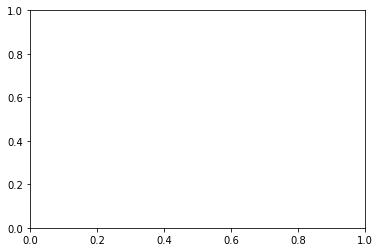

In [4]:
# merge

merge.main(output_models_path, output_merge)

output_graph.mkdir(exist_ok=True, parents=True)

model_folders = find_models(output_models_path)

# Super graph containing all nodes and all found transformations
super_graph = find_graphs(output_models_path, output_merge)

# Split super graph up into a list of connected graphs
maps = get_graphs(super_graph)

print(len(super_graph.nodes))
print(super_graph.nodes)

draw_super(get_tf_filter_view(super_graph), output_models_path)

draw_graphs(maps)

transform_models(output_models_path, output_graph, get_tf_filter_view(maps[0]), visualize=False, save=True)